# Model: EfficientNetB0
Fine Tuned

## Warning ignored

In [18]:
import warnings
warnings.filterwarnings("ignore")

## Import Libraries

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## For Colab uncomment

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/MyDrive/Dataset/data.zip"

## Edit Paths

In [27]:
location = '/content/data'
no_of_classes = 38
batch_size = 32
size = 224

## Data loading

In [22]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

folder_dir = location
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            image_path = os.path.join(folder_dir, folder, file)
            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, (size, size))
            cv2.imwrite(image_path, img_resized)
            pbar.update(1)
picture_size = (size, size)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=22
)

Processing Images: 100%|██████████| 11864/11864 [00:24<00:00, 481.65it/s]


Found 11864 files belonging to 38 classes.
Using 9492 files for training.
Found 11864 files belonging to 38 classes.
Using 2372 files for validation.


## Model building

In [29]:
no_of_classes = 38

with stg.scope():
# Data Augmentation
    img_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.1, width_factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode='horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2)
    ], name="img_augmentation")

    # Load EfficientNetB0 base model
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(size, size, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom classification layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(no_of_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1)

callbacks = [lr_scheduler, early_stopping]

model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

## Model Train

In [30]:
model.trainable = True

history = model.fit(train_set, epochs=100, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

Epoch 1/100
297/297 [==============================] - 42s 97ms/step - loss: 3.1431 - accuracy: 0.1391 - val_loss: 2.0913 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 2/100
297/297 [==============================] - 24s 81ms/step - loss: 1.9098 - accuracy: 0.4089 - val_loss: 1.4153 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 3/100
297/297 [==============================] - 24s 80ms/step - loss: 1.4679 - accuracy: 0.5346 - val_loss: 1.1503 - val_accuracy: 0.6425 - lr: 0.0010
Epoch 4/100
297/297 [==============================] - 24s 80ms/step - loss: 1.2519 - accuracy: 0.6040 - val_loss: 1.0173 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 5/100
297/297 [==============================] - 23s 78ms/step - loss: 1.1149 - accuracy: 0.6335 - val_loss: 0.9100 - val_accuracy: 0.7116 - lr: 0.0010
Epoch 6/100
297/297 [==============================] - 24s 82ms/step - loss: 1.0011 - accuracy: 0.6723 - val_loss: 0.8409 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 7/100
297/297 [==============================]

## Evaluation

In [31]:
test_data_dir = location
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

Found 11864 images belonging to 38 classes.
Test accuracy: 0.9625758528709412


371/371 [==============================] - 31s 82ms/step
Accuracy: 0.9625758597437627


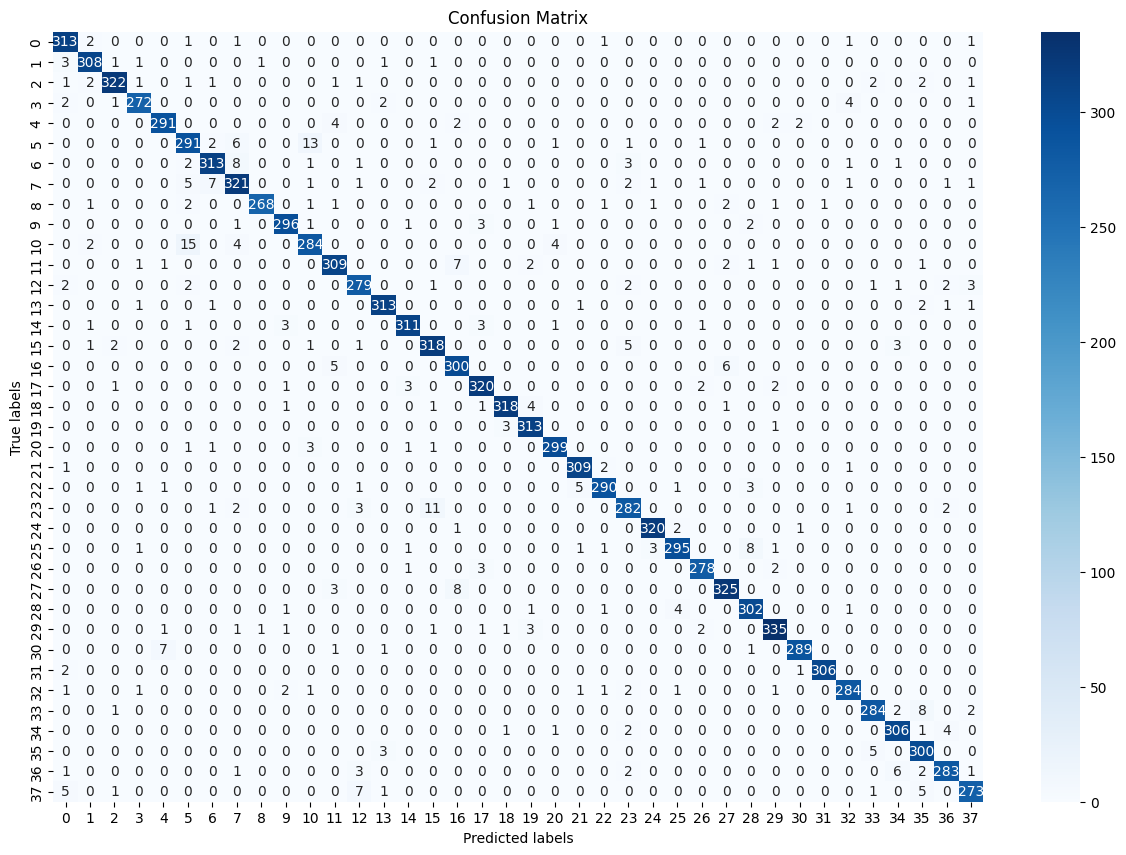

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       320
           1       0.97      0.97      0.97       316
           2       0.98      0.96      0.97       335
           3       0.97      0.96      0.97       282
           4       0.97      0.97      0.97       301
           5       0.91      0.92      0.91       316
           6       0.96      0.95      0.95       330
           7       0.93      0.93      0.93       345
           8       0.99      0.96      0.97       280
           9       0.97      0.97      0.97       305
          10       0.93      0.92      0.92       309
          11       0.95      0.95      0.95       325
          12       0.94      0.95      0.95       293
          13       0.98      0.98      0.98       320
          14       0.98      0.97      0.97       321
          15       0.94      0.95      0.95       333
          16       0.94      0.96      0.95       311
    

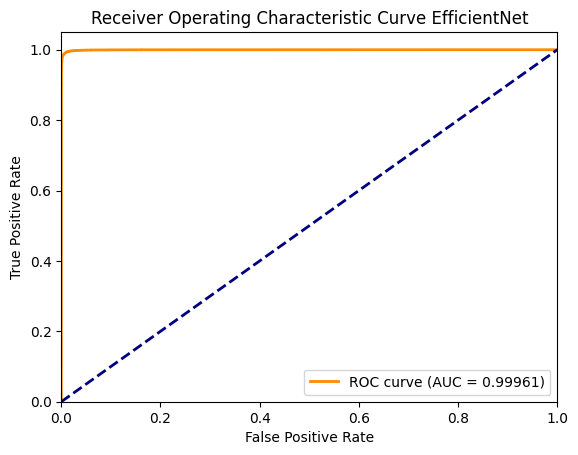

In [48]:
# Evaluate the model on test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve EfficientNet')
plt.legend(loc="lower right")
plt.show()

Training and Validation Loss Curves

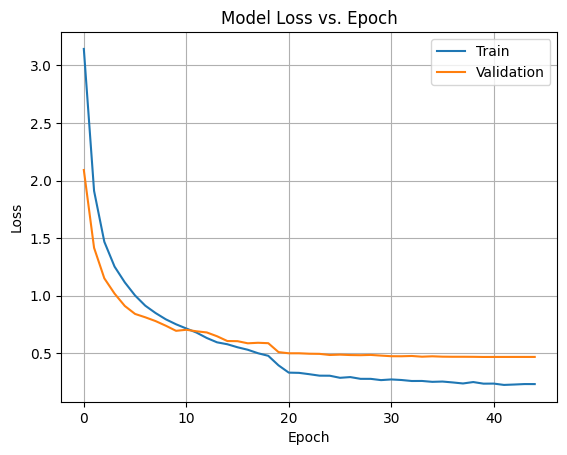

In [49]:
# plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

Accuracy Curves

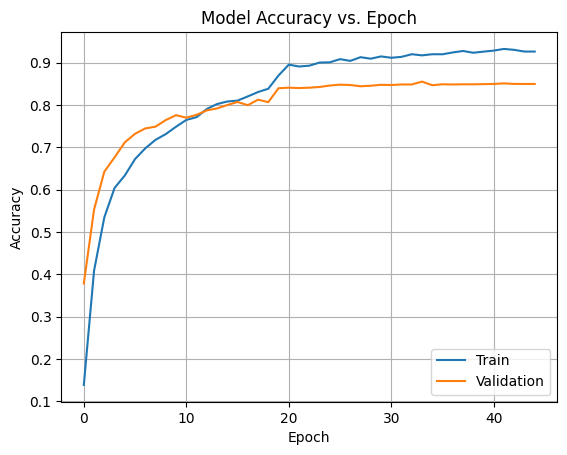

In [50]:
# plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.show()